# EDA on the API retrieved data about Manga Titles.

In [1]:
# Dependencies

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from ast import literal_eval
import re
from nltk.corpus import stopwords
from sklearn.metrics.pairwise import linear_kernel
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import RegexpTokenizer
import string
import random

pd.set_option('display.max_columns', None)

In [2]:
# Import dataframe from out_data.csv .
data = pd.read_csv('out_data.csv')

In [3]:
# Save a copy of the original data for genres analysis.
df = data.copy()

### Exploring the distribution of genres in our data.

In [4]:
# Explode genres list for each Manga.
df['genres'] = df['genres'].apply(literal_eval)
df = df.explode('genres')

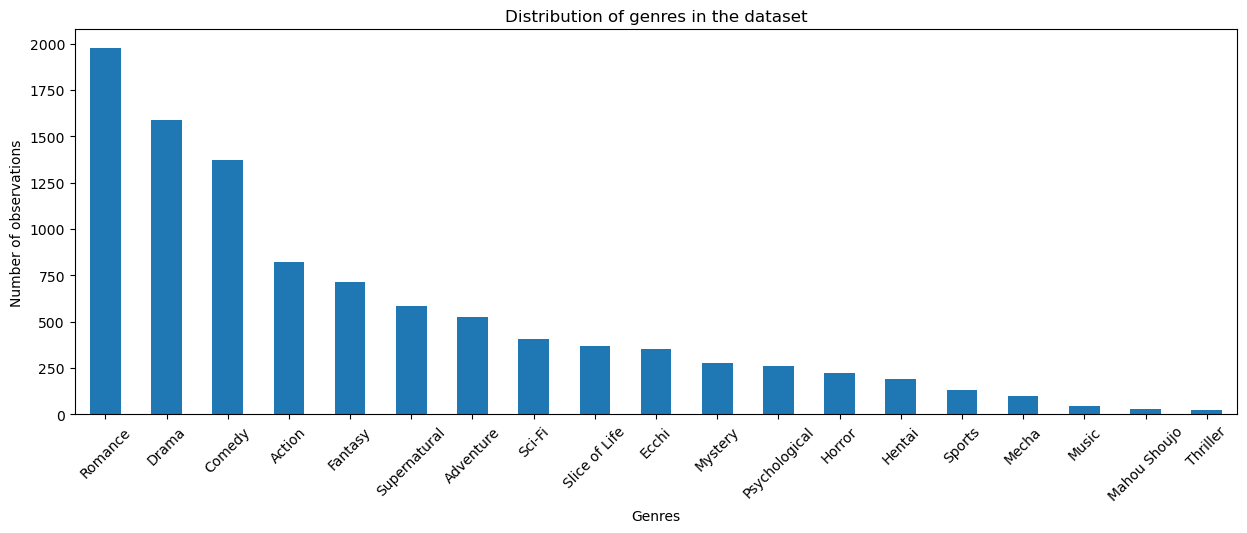

In [5]:
# Plot the distribution of genres in the dataset.
df['genres'].value_counts().plot.bar(x = 'genres',
                                     y ='count',
                                     figsize = (15,5),
                                     title = 'Distribution of genres in the dataset',
                                     xlabel = 'Genres',
                                     ylabel = 'Number of observations',
                                     rot = 45)
None

### Manga description — word count distribution.

In [6]:
# Calculating the word count for book description.
data['word_count'] = data['description'].apply(lambda x: len(str(x).split()))

<Figure size 500x500 with 0 Axes>

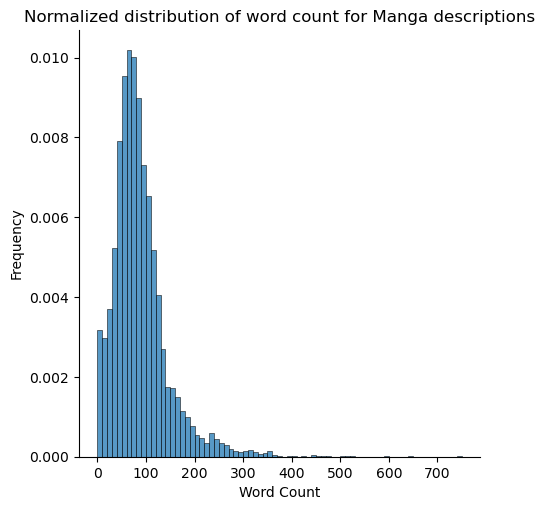

In [7]:
# Plot the word count distribution.
plt.figure(figsize = [5,5])
ax = sns.displot(data, x = 'word_count', binwidth = 10, stat = 'density')
ax.set(title = 'Normalized distribution of word count for Manga descriptions',
      xlabel = 'Word Count',
      ylabel = 'Frequency')
plt.show()

### Clean the description column for futher analysis.

In [8]:
# Number of titles without a description.
data['description'].isna().sum()

10

In [9]:
# Drop titles with NaN values in the description column.
data.dropna(subset = ['description'], inplace = True)

### Define functions for futher text cleaning.

In [10]:
def removeNonAscii(s):
    """ function to remove non ASCII characters """
    return "".join(i for i in s if  ord(i)<128)

def lower_case(text):
    """ function to convert all string characters to lowercase characters """
    return text.lower()

def remove_parenthesis_content(text):
    """ function to remove parentheses and content inside """
    parent_pattern = re.compile('\(.*\)')
    return parent_pattern.sub(r'', text)
    
def remove_stop_words(text):
    """ function to remove stop words from the text """
    text = text.split()
    stops = set(stopwords.words("english"))
    text = [w for w in text if not w in stops]
    return  " ".join(text)

def remove_punctuation(text):
    """ function to remove special characters: punctuation """
    tokenizer = RegexpTokenizer(r'\w+')
    text = tokenizer.tokenize(text)
    return " ".join(text)

def remove_html(text):
    """ function to remove special characters: html tags """
    html_pattern = re.compile('<.*?>')
    return html_pattern.sub(r'', text)

In [11]:
# Applying all the functions in description and storing as a cleaned_desc
data['cleaned_description'] = data['description'].apply(removeNonAscii)
data['cleaned_description'] = data['cleaned_description'].apply(lower_case)
data['cleaned_description'] = data['cleaned_description'].apply(remove_stop_words)
data['cleaned_description'] = data['cleaned_description'].apply(remove_parenthesis_content)
data['cleaned_description'] = data['cleaned_description'].apply(remove_html)
data['cleaned_description'] = data['cleaned_description'].apply(remove_punctuation)

In [12]:
data['description'][6]

'"The world is a very small place, but for those who know it...it is very, very large. And the world, when it is viewed by those who \'know\'&mdash; is far larger than just one world can hold!"<br><br>\nThe famous CLAMP brings back the characters from all their creations for an ultimate showdown in this multi-dimensional tale.<br><br>\nThis is the story of four travelers, bound by fate and by prophesied future. Sakura is the princess of Clow Country, and possessor of a strange power that promises to change the world. Syaoran is an aspiring archaeologist and her childhood friend. When Sakura is endangered by the plan a certain man has for the future, the princess\' memories are scattered across dimensions in the form of feathers, and Syaoran is forced to go on a desperate journey to retrieve them. They are accompanied by Fay D. Flourite, a magician running from the horrible truth of his past, and Kurogane, a rough-mannered ninja trying to get back to his world. However, the ability to c

In [13]:
data['cleaned_description'][6]

'the world small place know it it very large world viewed know mdash far larger one world hold famous clamp brings back characters creations ultimate showdown multi dimensional tale story four travelers bound fate prophesied future sakura princess clow country possessor strange power promises change world syaoran aspiring archaeologist childhood friend sakura endangered plan certain man future princess memories scattered across dimensions form feathers syaoran forced go desperate journey retrieve them accompanied fay d flourite magician running horrible truth past kurogane rough mannered ninja trying get back world however ability cross worlds demands great price must pay dimensional witch values most order save princess syaoran must give relationship her even gathers sakura s memories never remember past together world simple moment four made decision destinies sealed tragic course as everyone group secrets visions future seen prophesies made cruel future lies ahead reads betrayal aba

## Ngram Distributions

In [29]:
class Ngram(object):
    """ class to define and calculate ngram combinations on text data"""
    def __init__(self, ngram_range, stop_words, column):
        # Converting text descriptions into vectors using TF-IDF.
        self.tf = TfidfVectorizer(ngram_range = ngram_range, stop_words = stop_words, lowercase = False)
        self.tfidf_matrix = self.tf.fit_transform(column)
        self.total_words = self.tfidf_matrix.sum(axis = 0)
        self.freq = self.freq_setter()
        self.ngram = self.ngram_setter()
    
    # use setter functions to improve functionalty and readability
    
    def freq_setter(self):
        """ method to calculate the ngram words frequency of the class """
        freq = [(word, self.total_words[0, idx]) for word, idx in self.tf.vocabulary_.items()]
        return sorted(freq, key = lambda x: x[1], reverse=True)
    
    def ngram_setter(self):
        """ method to create a pandas dataframe that contains the resulting ngrams with their frequency """
        ngram = pd.DataFrame(self.freq)
        ngram.rename(columns = {0:'ngram', 1: 'count'}, inplace = True)
        return ngram

    def word_count(self, n = 20):
        """ method to return the top n ngram count results"""
        return self.ngram.head(n)

    

### Bigram distribution for the Manga description.

In [30]:
# Create a Bigram instance of Ngram
Bigram = Ngram((2,2), 'english', data['cleaned_description'])
bigram = Bigram.word_count()

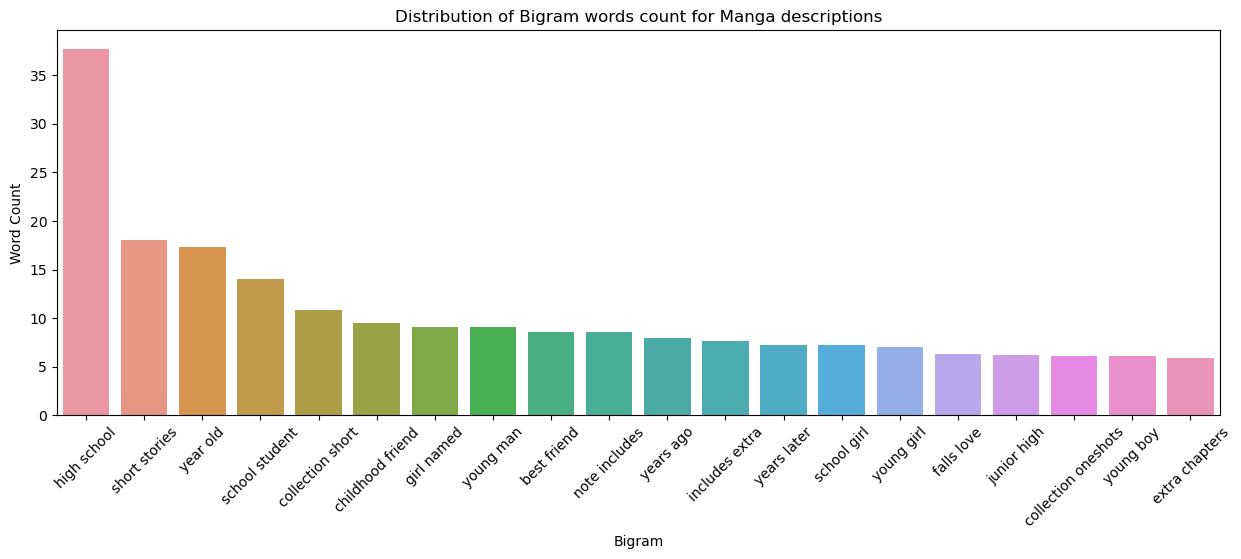

In [31]:
# Plot the top 20 Bigram disribution in the Manga description.
plt.figure(figsize = [15,5])
ax = sns.barplot( x = bigram['ngram'], y=bigram['count'])
ax.set(title = 'Distribution of Bigram words count for Manga descriptions',
      xlabel = 'Bigram',
      ylabel = 'Word Count')
plt.xticks(rotation = 45)
plt.show()

## Trigram distribution for the book description

In [17]:
Trigram = Ngram((3,3), 'english', data['cleaned_description'])
trigram = Trigram.word_count()

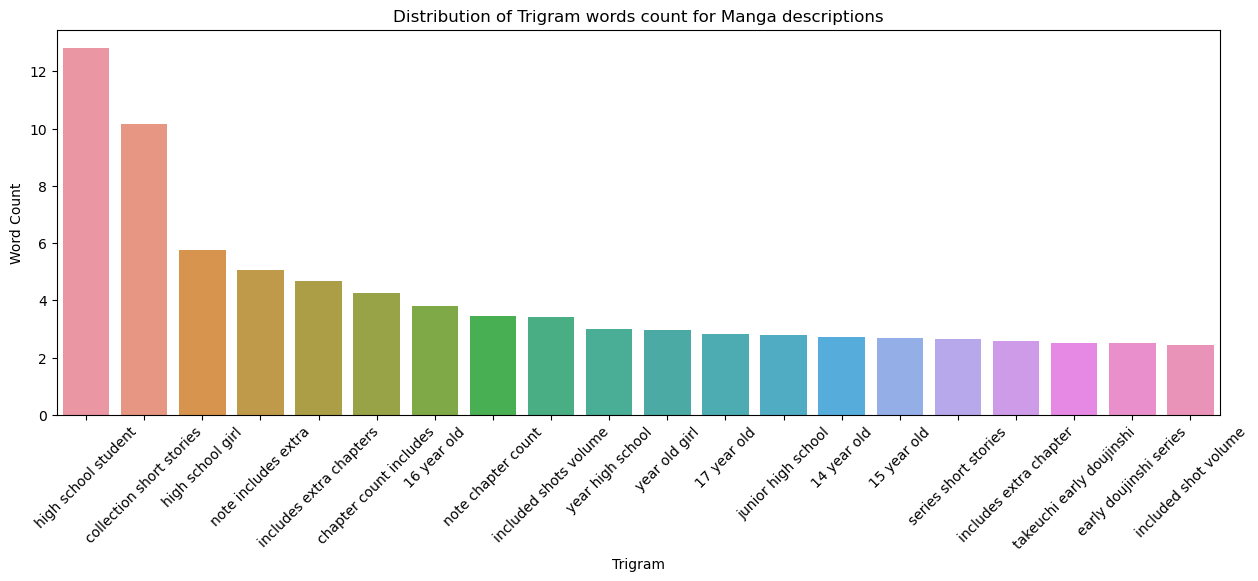

In [18]:
# Plot the top 20 Trigram disribution in the Manga description.
plt.figure(figsize = [15,5])
ax = sns.barplot(x = trigram['ngram'], y=trigram['count'])
ax.set(title = 'Distribution of Trigram words count for Manga descriptions',
      xlabel = 'Trigram',
      ylabel = 'Word Count')
plt.xticks(rotation = 45)
plt.show()

#### Need to remove patterns such as Chapter Info, Includes... extra shots ... for better analysis

## Export resulting dataset as 'cleaned_out_data.csv'

In [19]:
data.to_csv('cleaned_out_data.csv', index = False)